In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import random

time: 2.23 ms (started: 2022-10-23 01:14:45 +00:00)


In [ ]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.86 s (started: 2022-10-23 01:14:46 +00:00)


In [ ]:
%load_ext autotime
%load_ext Cython

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
time: 6.88 ms (started: 2022-10-23 01:14:50 +00:00)


In [ ]:
# Clonamos el repositorio
!git clone https://github.com/BenjaminIrarrazabal/Procesamiento_Avanzado_de_Imagenes

Cloning into 'Procesamiento_Avanzado_de_Imagenes'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 381 (delta 1), reused 376 (delta 1), pack-reused 0
Receiving objects: 100% (381/381), 34.01 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
time: 3.55 s (started: 2022-10-23 01:14:50 +00:00)


In [ ]:
# Nos posicionamos en la carpeta de imágenes de la tarea 4 (cabe destacar que son las mismas que la tarea 3)
%cd Procesamiento_Avanzado_de_Imagenes/ImagenesT3

/content/Procesamiento_Avanzado_de_Imagenes/ImagenesT3/Procesamiento_Avanzado_de_Imagenes/ImagenesT3/Procesamiento_Avanzado_de_Imagenes/ImagenesT3/Procesamiento_Avanzado_de_Imagenes/ImagenesT3/Procesamiento_Avanzado_de_Imagenes/ImagenesT3/Procesamiento_Avanzado_de_Imagenes/ImagenesT3
time: 7.5 ms (started: 2022-10-23 01:14:53 +00:00)


In [ ]:
# Confirmamos que estén las carpetas
!ls

car_side  chair  pedestrian
time: 161 ms (started: 2022-10-23 01:14:53 +00:00)


In [ ]:
def redimension(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Se redimensiona la imagen
  out_img = cv2.resize(gray_img, dsize=(24, 24), interpolation = cv2.INTER_AREA)
  # Se retorna del tipo np.float32
  return np.float32(out_img)

time: 4.78 ms (started: 2022-10-23 01:14:54 +00:00)


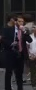

time: 15.4 ms (started: 2022-10-23 01:14:54 +00:00)


In [ ]:
img = cv2.imread('pedestrian/1.png')
cv2_imshow(img)
cv2_imshow(redimension(img))

# Parte 1. Lectura de imágenes redimensionadas y separación de conjuntos

In [ ]:
# Se leen las imágenes recorriendo los archivos dentro de las 
# Se codifica la clase como 1 para personas y como -1 para no personas

pedestrian_path = glob.glob('pedestrian//*.png') # nombres en file[11:-4]
chair_path = glob.glob('chair//*.jpg') # nombres en file[6:-4]
car_path = glob.glob('car_side//*.jpg') # nombres en file[9:-4]

Images = [] # Lista que guarda las 370 imágenes, redimensionadas a 24x24
Labels = [] # Lista que guarda las etiquetas de las imágenes

for file in pedestrian_path:
    img = cv2.imread(file)
    Images.append(redimension(img)) # se agregan las imagenes redimensionadas
    Labels.append(1) # se codifica la clase 

for file in chair_path:
    img = cv2.imread(file)
    Images.append(redimension(img)) # se agregan las imagenes redimensionadas
    Labels.append(-1) # se codifica la clase 

for file in car_path:
    img = cv2.imread(file)
    Images.append(redimension(img)) # se agregan las imagenes redimensionadas
    Labels.append(-1) # se codifica la clase 

time: 457 ms (started: 2022-10-23 01:14:54 +00:00)


In [ ]:
print(len(Images), len(Labels))

370 370
time: 6.14 ms (started: 2022-10-23 01:14:54 +00:00)


In [ ]:
# Separamos los conjuntos de entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(Images, Labels, test_size=0.20, stratify=Labels, random_state = 20) 

time: 5 ms (started: 2022-10-23 01:14:54 +00:00)


# Parte 2. Imágenes Integrales

In [ ]:
# La función para calcular la imagen integral de una imagen de entrada se realiza mediante el concepto de Raster Scanning, el cual será abordado en el informe.
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t, ndim=2] Integral_Image(np.ndarray[np.float32_t, ndim=2] input):
  cdef np.ndarray[np.float32_t, ndim=2] output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32) # definimos la salida (24x24)

  cdef int i, j # Enteros para recorrer la imagen de entrada

  # Primero, analizamos los casos borde:
  # Primera posición
  output[0][0] = input[0][0]
  # 1ra Fila:
  for j in range(1, input.shape[1]): # Recorremos Columnas
    output[0][j] = output[0][j-1] + input[0][j]
  
  # 1ra Columna:
  for i in range(1, input.shape[0]): # Recorremos Filas
    output[i][0] = output[i-1][0] + input[i][0]
  
  # Ahora analizamos el resto de los casos, partiendo de la posición [1,1]
  for j in range(1, input.shape[1]):
    for i in range(1, input.shape[0]):
      output[i][j] = output[i][j-1] + output[i-1][j] - output[i-1][j-1] + input[i][j]
  return output

time: 3.43 ms (started: 2022-10-23 01:14:54 +00:00)


# Parte 3. Parametrización de máscaras Haar

In [ ]:
def Haar_Mask():
  # Para cada tipo de máscara existirán 9 diferentes combinaciones de anchos/altos
  # para esto, se comenzará en orden de tipos, ie, 0, 1, 2, 3, 4
  parameters = []
  # A continuación se mencionan las dimensiones de las máscaras (cabe destacar que las máscaras 0, 1 y 4 son de igual tamaño y las 2 y 3 entre sí igual)
  # Para las máscaras tipo 0, 1 y 4, se tendrán las siguientes combinaciones de ancho/alto:
  # 1.  4x4          5.  8x8          9.  12x12
  # 2.  4x8          6.  8x12
  # 3.  4x12         7.  12x4
  # 4.  8x4          8.  12x8

  # Para la máscara tipo 2 y 3, se tendrán las siguientes combinaciones de ancho/alto:
  # 1.  3x3          5.  6x6          9.  9x9
  # 2.  3x6          6.  6x9
  # 3.  3x9          7.  9x3
  # 4.  6x3          8.  9x6
  
  for i in range(0, 24, 3): # se itera 0, 3, 6, 9, 12, ..., 24 (ventana deslizante) para i y j.
    for j in range(0, 24, 3):

      x1, y1 = i, j # la esquina superior izquierda de la máscara calza con la posición i,j

      # se realizarán las 9 combinaciones para ambas polaridades usando todos los tipos, para tener todas las características posibles.
      for polaridad in [1, -1]:

        for tipo in [0, 1, 4]: # iteramos sobre los tipos que ocupen los mismos anchos/altos
          for ancho in [4, 8, 12]:
            for alto in [4, 8, 12]:
              # se define la esquina inferior derecha de la máscara considerando casos borde
              if (x1 == 0) and (y1 == 0):
                x2, y2 = x1+ancho-1, y1+alto-1
              elif (x1 == 0):
                x2, y2 = x1+ancho-1, y1+alto
              elif (y1 == 0):
                x2, y2 = x1+ancho, y1+alto-1
              else:
                x2, y2 = x1+ancho, y1+alto 

              if (x2 <= 23) and (y2 <= 23): #solo si está dentro de los límites (24x24) se utiliza
                parameters.append([y1, x1, y2, x2, tipo, polaridad])

        for tipo in [2, 3]: # iteramos sobre los tipos que ocupen los mismos anchos/altos
          for ancho in [3, 6, 9]:
            for alto in [3, 6, 9]:
              # se define la esquina inferior derecha de la máscara considerando casos borde
              if (x1 == 0) and (y1 == 0):
                x2, y2 = x1+ancho-1, y1+alto-1
              elif (x1 == 0):
                x2, y2 = x1+ancho-1, y1+alto
              elif (y1 == 0):
                x2, y2 = x1+ancho, y1+alto-1
              else:
                x2, y2 = x1+ancho, y1+alto

              if (x2 <= 23) and (y2 <= 23): #solo si está dentro de los límites (24x24) se utiliza
                parameters.append([y1, x1, y2, x2, tipo, polaridad])

  return parameters

time: 7.03 ms (started: 2022-10-23 01:14:54 +00:00)


# Parte 4. Vectores de Características

In [ ]:
def Haar_Features(images, parameters):
  Features = [] # este arreglo guardará las características de todas las imágenes
  for i in range(len(images)):
    feat = [] # esta lista temporal guardará las características de c/imagen para luego guardarla en el arreglo principal
    img = images[i] # imagen a la cual se aplicarán todas las máscaras parametrizadas. (debe ser imagen integral)
  
    for j in range(len(parameters)):
      # Para cada máscara parametrizada rescatamos su posición, tipo y polaridad
      p = parameters[j]
      y1 = p[0]
      x1 = p[1]
      y2 = p[2]
      x2 = p[3]
      tipo = p[4]
      polaridad = p[5]
      # A partir de sus posiciones calculamos el ancho y alto de la máscara, que nos servirá para
      # realizar las sumas y restas adecuadas.
      if x1 == 0:
        alto = x2-x1+1
      else:
        alto = x2-x1
      if y1 == 0:
        ancho = y2-y1+1
      else:
        ancho = y2-y1
      # Se analiza el tipo de máscara para saber que operación debe realizar el algoritmo.
      # Para cada tipo de máscara se deben analizar los casos bordes, cuando estamos en 0,0 , en 0,j (con j entre 1 y 23)
      # en i,0 (con i entre 1 y 23) y finalmente con i,j (cuando ambos son distintos de 0).
      if tipo == 0:
        if (x1 == 0) and (y1 == 0):
          fpos = img[x2][y2-ancho//2]
          fneg = img[x2][y2]-fpos
        elif (x1 == 0):
          fpos = img[x2][y2-ancho//2] - img[x2][y2-ancho]
          fneg = img[x2][y2] - img[x2][y2-ancho//2]
        elif (y1 == 0):
          fpos = img[x2][y2-ancho//2] - img[x1-1][y2-ancho//2]
          fneg = img[x2][y2] - img[x2-alto][y2] - fpos
        else:
          fpos = img[x2][y2-ancho//2] - img[x2][y2-ancho] - img[x1-1][y2-ancho//2] + img[x1-1][y1-1]
          fneg = img[x2][y2] - img[x2-alto][y2] - img[x2][y2-ancho//2] + img[x1-1][y2-ancho//2]
        f = (fpos - fneg) * polaridad

      elif tipo == 1:
        if (x1 == 0) and (y1 == 0):
          fpos = img[x2][y2] - img[x2-alto//2][y2]
          fneg = img[x2-alto//2][y2]
        elif (x1 == 0):
          fpos = img[x2][y2] - img[x2-alto//2][y2] - img[x2][y2-ancho] + img[x2-alto//2][y2-ancho]
          fneg = img[x2-alto//2][y2] - img[x2-alto//2][y2-ancho]
        elif (y1 == 0):
          fpos = img[x2][y2] - img[x2-alto//2][y2]
          fneg = img[x2-alto//2][y2] - img[x2-alto][y2]
        else:
          fpos = img[x2][y2] - img[x2][y2-ancho] - img[x2-alto//2][y2] + img[x2-alto//2][y2-ancho]
          fneg = img[x2-alto//2][y2] - img[x2-alto//2][y2-ancho] - img[x2-alto][y2] + img[x1-1][y1-1]
        f = (fpos - fneg) * polaridad

      elif tipo == 2:
        if (x1 == 0) and (y1 == 0):
          fpos = img[x2][y2] - img[x2][y2-ancho//3] + img[x2][y2-2*ancho//3]
          fneg = img[x2][y2-ancho//3] - img[x2][y2-2*ancho//3]
        elif (x1 == 0):
          fpos = img[x2][y2] - img[x2][y2-ancho//3] - img[x2][y2-ancho] + img[x2][y2-2*ancho//3]
          fneg = img[x2][y2-ancho//3] - img[x2][y2-2*ancho//3]
        elif (y1 == 0):
          fneg = img[x2][y2-ancho//3] - img[x2-alto][y2-ancho//3] - img[x2][y2-2*ancho//3] + img[x2-alto][y2-2*ancho//3]
          fpos = img[x2][y2] - img[x2-alto][y2] - fneg
        else:
          fneg = img[x2][y2-ancho//3] - img[x2-alto][y2-ancho//3] - img[x2][y2-2*ancho//3] + img[x2-alto][y2-2*ancho//3]
          fpos = img[x2][y2] - img[x2-alto][y2] - img[x2][y2-ancho] + img[x1-1][y1-1] - fneg
        f = (fpos - fneg) * polaridad

      elif tipo == 3:
        if (x1 == 0) and (y1 == 0):
          fneg = img[x2-alto//3][y2] - img[x2-2*alto//3][y2]
          fpos = img[x2][y2] - fneg
        elif (x1 == 0):
          fneg = img[x2-alto//3][y2] - img[x2-2*alto//3][y2] - img[x2-alto//3][y2-ancho] + img[x1][y1-1]
          fpos = img[x2][y2] - img[x2][y2-ancho] - fneg
        elif (y1 == 0):
          fneg = img[x2-alto//3][y2] - img[x2-2*alto//3][y2]
          fpos = img[x2][y2] - img[x2-alto][y2] - fneg
        else:
          fneg = img[x2-alto//3][y2] - img[x2-alto//3][y2-ancho] - img[x2-2*alto//3][y2] + img[x2-2*alto//3][y2-ancho]
          fpos = img[x2][y2] - img[x2][y2-ancho] - img[x2-alto][y2] + img[x1-1][y1-1] - fneg
        f = (fpos - fneg) * polaridad

      elif tipo == 4:
        if (x1 == 0) and (y1 == 0):
          fneg = img[x2-alto//2][y2] - 2*img[x2-alto//2][y2-ancho//2] + img[x2][y2-ancho//2]
          fpos = img[x2][y2] - fneg
        elif (x1 == 0):
          fneg = img[x2-alto//2][y2] - 2*img[x2-alto//2][y2-ancho//2] + img[x2][y2-ancho//2] - img[x2][y2-ancho] + img[x2-alto//2][y2-ancho]
          fpos = img[x2][y2] - img[x2][y2-ancho] - fneg
        elif (y1 == 0):
          fneg = img[x2][y2-ancho//2] - 2*img[x2-alto//2][y2-ancho//2] + img[x2-alto//2][y2] - img[x2-alto][y2] + img[x2-alto][y2-ancho//2]
          fpos = img[x2][y2] - img[x2-alto][y2] - fneg
        else:
          fneg = img[x2][y2-ancho//2] - img[x2][y2-ancho] - 2*img[x2-alto//2][y2-ancho//2] + img[x2-alto//2][y2-ancho] + img[x2-alto//2][y2] - img[x2-alto][y2] + img[x2-alto][y2-ancho//2]
          fpos = img[x2][y2] - img[x2][y2-ancho] - img[x2-alto][y2] + img[x1-1][y1-1] - fneg
        f = (fpos - fneg) * polaridad
      # Agregamos la característica a la lista variable
      feat.append(f)
    # cuando ya recorremos todos los parámetros para una imagen guardamos el vector y seguimos con la siguiente
    Features.append(feat)

  return np.array(Features)

time: 28 ms (started: 2022-10-23 01:14:54 +00:00)


# Parte 5. Clasificador Adaboost

## 5.a. Base de Clasificadores Débiles h(x,u)

In [ ]:
def h(x,u):
  # La función h(x,u) busca generar un clasificador débil mediante un umbral definido (u)
  # Sea x un arreglo:
  # x > u y x < u, devuelven un arreglo con True en las posiciones que cumplen la condición
  lpos = x > u 
  lneg = x <= u
  # Luego, al multiplicar estos arreglos por 1 o -1, los valores True toman este factor y los False quedan en 0
  pos = lpos * 1
  neg = lneg * -1
  # Finalmente, si sumamos ambos arreglos (posición a posición)
  # obtenemos un arreglo con -1 cuando x_i < u y 1 cuando x_i > u.
  return pos + neg

time: 1.47 ms (started: 2022-10-23 01:14:54 +00:00)


## 5.b. Mejor umbral para clasificador débil

In [ ]:
def Best_U(X, y, w):
  # X es la matriz de características, en el caso del conjunto de train, será de 296 x 3030
  # y es el vector de clases, tendrá valores 1 o -1 según la imagen contenga una persona u otro. (largo 296)
  # w es el vector de pesos de largo 296
  # h(x,u) se construye con la función anterior
  best_u = [] # esta lista guardará los mejores u para cada iteración.
  best_r = [] # esta lista guardará el mejor r para cada iteración.
  for j in range(X.shape[1]): # Recorremos las columnas de la matriz de características
    Xcol = X[:,j] # Tomamos cada columna (ie, cada característica)
    # Tomamos el valor mínimo y máximo
    minX = min(Xcol)
    maxX = max(Xcol)
    # En cada iteración generamos una lista de r, tendrá 10 valores y luego sacaremos el mejor de estos.
    r = []
    # tendremos 10 u para cada iteración, luego guardaremos el mejor en best_u
    u = np.linspace(minX, maxX, 10)

    # Recorremos los 10 valores de u y guardamos los r correspondientes
    for k in range(len(u)):
      r.append(np.sum(w * y * h(Xcol, u[k])))
    # buscamos el r máximo para cada característica
    maxR = max(r)
    ind = r.index(maxR)
    # guardamos el mejor u y r en la lista correspondiente
    best_u.append(u[ind])
    best_r.append(maxR)
    
  return best_u, best_r

time: 4.08 ms (started: 2022-10-23 01:14:54 +00:00)


## 5.c. Entrenamiento Adaboost

In [ ]:
def a_t(r):
  return 0.5 * np.log((1+r)/(1-r))

def Train_Adaboost(X, y, T = 10):
  N = X.shape[0] # tomamos el valor de N
  # inicializamos el vector de pesos
  w = np.ones(N) * (1/N)
  # listas que guardan los elementos que permiten construir y evaluar el clasificador fuerte
  at = np.zeros(T)
  it = []
  ut = np.zeros(T)
  ht = []

  # iteración principal
  for t in range(T):
    U, R = Best_U(X, y, w)

    alphas = []
    for i in range(len(R)):
      alphas.append(a_t(R[i]))
    rmax = max(R)
    indmax = R.index(rmax) # este será el índice del elemento a guardar

    # guardamos los elementos necesarios
    at[t] = alphas[indmax]
    it.append(indmax)
    ut[t] = U[indmax]
    ht.append(h(X[:,it[t]], ut[t]))
  
    # Actualizamos y normalizamos los pesos
    w = w * np.exp(-1 * at[t] * y * ht[t])
    w = w / np.sum(w)

    # se realiza la siguiente iteración...

  return at, np.array(it), ut

time: 9.43 ms (started: 2022-10-23 01:14:54 +00:00)


## 5.d. Clasificación

In [ ]:
def Adaboost_classify(X, it, ut, at):
  # Se realiza la clasificación utilizando la función del enunciado
  H = np.sign(np.sum(at * h(X[it], ut)))
  return H

time: 1.32 ms (started: 2022-10-23 01:14:54 +00:00)


In [ ]:
# Classify_all permite ingresar una matriz de características y clasificar todo directamente
def Classify_all(X, it, ut, at):
  pred = []
  for i in range(X.shape[0]):
    pred.append(Adaboost_classify(X[i], it, ut, at))
  return np.array(pred)

time: 1.59 ms (started: 2022-10-23 01:14:54 +00:00)


# Parte 6. Cálculo de imágenes integrales y características Haar

In [ ]:
# Con las siguientes iteraciones se calcula la imagen integral de la imagen redimensionada 
for img in X_train:
  img = Integral_Image(img)
for img in X_test:
  img = Integral_Image(img)

# Creamos arreglo de máscaras parametrizadas
parameters = Haar_Mask()

# Extraemos características
X_train_Features = Haar_Features(X_train, parameters)
X_test_Features = Haar_Features(X_test, parameters)

time: 17.8 s (started: 2022-10-23 01:14:54 +00:00)


In [ ]:
# Se realiza un arreglo de numpy para no tener errores
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

time: 1.08 ms (started: 2022-10-23 01:15:12 +00:00)


# Parte 7. Entrenar clasificador Adaboost (T = 10)

In [ ]:
# Entrenamiento:
at, it, ut = Train_Adaboost(X_train_Features, Y_train)

time: 9.52 s (started: 2022-10-23 01:15:12 +00:00)


In [ ]:
pred_train = Classify_all(X_train_Features, it, ut, at)
pred_test = Classify_all(X_test_Features, it, ut, at)

time: 13.7 ms (started: 2022-10-23 01:15:22 +00:00)


## 7.a. Evaluación sobre conjunto de entrenamiento

Text(30.5, 0.5, 'True Labels')

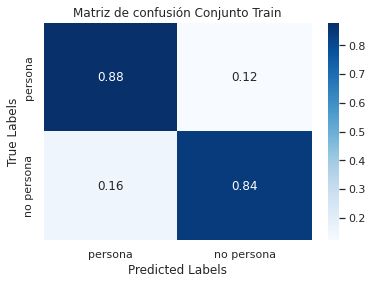

time: 244 ms (started: 2022-10-23 01:15:22 +00:00)


In [ ]:
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_train, pred_train, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues',xticklabels = ['persona', 'no persona'], yticklabels = ['persona', 'no persona']) 

ax.set_title('Matriz de confusión Conjunto Train') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 

In [ ]:
print('Accuracy Conjunto Train: ', accuracy_score(Y_train, pred_train))

Accuracy Conjunto Train:  0.8614864864864865
time: 1.5 ms (started: 2022-10-23 01:15:22 +00:00)


## 7.b. Evaluación sobre conjunto de prueba

Text(30.5, 0.5, 'True Labels')

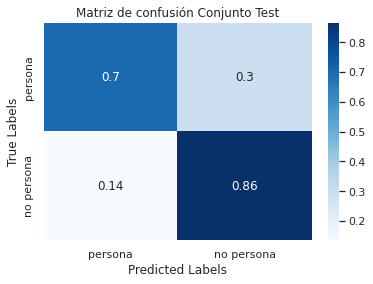

time: 243 ms (started: 2022-10-23 01:15:22 +00:00)


In [ ]:
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_test, pred_test, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues',xticklabels = ['persona', 'no persona'], yticklabels = ['persona', 'no persona'])

ax.set_title('Matriz de confusión Conjunto Test') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 

In [ ]:
print('Accuracy Conjunto Test: ', accuracy_score(Y_test, pred_test))

Accuracy Conjunto Test:  0.7837837837837838
time: 3.94 ms (started: 2022-10-23 01:15:22 +00:00)


# Parte 8. Entrenamiento usando T = 5 y T = 20

## Entrenamiento con T = 5

Accuracy Conjunto Train:  0.7905405405405406
Accuracy Conjunto Test:  0.8378378378378378


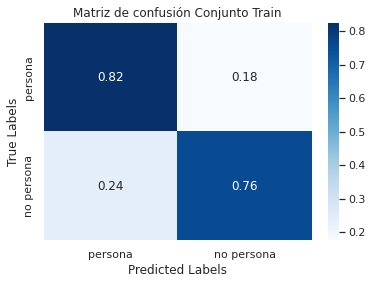

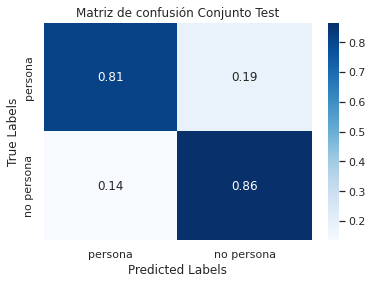

time: 4.93 s (started: 2022-10-23 01:15:22 +00:00)


In [ ]:
# Entrenamiento:
at, it, ut = Train_Adaboost(X_train_Features, Y_train, T = 5)
pred_train = Classify_all(X_train_Features, it, ut, at)
pred_test = Classify_all(X_test_Features, it, ut, at)
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_train, pred_train, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues',xticklabels = ['persona', 'no persona'], yticklabels = ['persona', 'no persona']) 

ax.set_title('Matriz de confusión Conjunto Train') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
print('Accuracy Conjunto Train: ', accuracy_score(Y_train, pred_train))

sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_test, pred_test, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues',xticklabels = ['persona', 'no persona'], yticklabels = ['persona', 'no persona'])
ax.set_title('Matriz de confusión Conjunto Test') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
print('Accuracy Conjunto Test: ', accuracy_score(Y_test, pred_test))

## Entrenamiento con T = 20

Accuracy Conjunto Train:  0.9391891891891891
Accuracy Conjunto Test:  0.7297297297297297


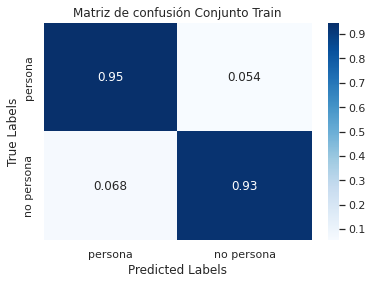

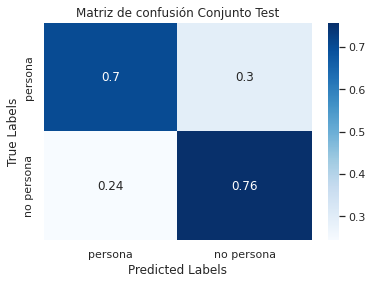

time: 18.1 s (started: 2022-10-23 01:15:27 +00:00)


In [ ]:
# Entrenamiento:
at, it, ut = Train_Adaboost(X_train_Features, Y_train, T = 20)
pred_train = Classify_all(X_train_Features, it, ut, at)
pred_test = Classify_all(X_test_Features, it, ut, at)
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_train, pred_train, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues',xticklabels = ['persona', 'no persona'], yticklabels = ['persona', 'no persona']) 

ax.set_title('Matriz de confusión Conjunto Train') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
print('Accuracy Conjunto Train: ', accuracy_score(Y_train, pred_train))

sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_test, pred_test, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues',xticklabels = ['persona', 'no persona'], yticklabels = ['persona', 'no persona'])
ax.set_title('Matriz de confusión Conjunto Test') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
print('Accuracy Conjunto Test: ', accuracy_score(Y_test, pred_test))

# Parte 10. Ampliar imágenes y dibujar las 5 mejores máscaras.

In [ ]:
def redimension2(img):
  # Se redimensiona la imagen
  out_img = cv2.resize(img, dsize=(192, 192), interpolation = cv2.INTER_AREA)
  # Se retorna del tipo np.float32
  return np.float32(out_img)

time: 860 µs (started: 2022-10-23 01:15:45 +00:00)


In [ ]:
def DrawMask(img, mask_p): 
  # los indices se amplifican por 8 ya que 192/24 = 8, ie, ampliamos la imagen 8 veces y por ende las máscaras igual para ser dibujadas
  y1 = mask_p[0] * 8
  x1 = mask_p[1] * 8
  y2 = mask_p[2] * 8
  x2 = mask_p[3] * 8
  tipo = mask_p[4]
  polaridad = mask_p[5]
  # A partir de sus posiciones calculamos el ancho y alto de la máscara, que nos servirá para
  # realizar las sumas y restas adecuadas.
  if x1 == 0:
    alto = x2-x1+1
  else:
    alto = x2-x1
  if y1 == 0:
    ancho = y2-y1+1
  else:
    ancho = y2-y1
  # colores, rojo para el lado positivo, azul para el negativo de la máscara
  cp = (0,0,255)
  cn = (255,0,0)
  t = 1 # espesor
  if tipo == 0:
    if polaridad == 1:
      img = cv2.rectangle(img, (x1,y1), (x2, y2-ancho//2), cp, t)
      img = cv2.rectangle(img, (x1,y1+ancho//2), (x2, y2), cn, t)
    else:
      img = cv2.rectangle(img, (x1,y1), (x2, y2-ancho//2), cn, t)
      img = cv2.rectangle(img, (x1,y1+ancho//2), (x2, y2), cp, t)

  elif tipo == 1:
    if polaridad == 1:
      img = cv2.rectangle(img, (x1,y1), (x2-alto//2,y2), cn, t)
      img = cv2.rectangle(img, (x1+alto//2, y1), (x2,y2), cp, t)
    else:
      img = cv2.rectangle(img, (x1,y1), (x2-alto//2,y2), cp, t)
      img = cv2.rectangle(img, (x1+alto//2, y1), (x2,y2), cn, t)

  elif tipo == 2:
    if polaridad == 1:
      img = cv2.rectangle(img, (x1,y1), (x2,y2-2*ancho//3), cp, t)
      img = cv2.rectangle(img, (x1,y1+ancho//3), (x2,y2-ancho//3), cn, t)
      img = cv2.rectangle(img, (x1,y1+2*ancho//3), (x2,y2), cp, t)
    else:
      img = cv2.rectangle(img, (x1,y1), (x2,y2-2*ancho//3), cn, t)
      img = cv2.rectangle(img, (x1,y1+ancho//3), (x2,y2-ancho//3), cp, t)
      img = cv2.rectangle(img, (x1,y1+2*ancho//3), (x2,y2), cn, t)

  elif tipo == 3:
    if polaridad == 1:
      img = cv2.rectangle(img, (x1,y1), (x2-2*alto//3, y2), cp, t)
      img = cv2.rectangle(img, (x1+alto//3, y1), (x2-alto//3, y2), cn, t)
      img = cv2.rectangle(img, (x1+2*alto//3, y1), (x2,y2), cp, t)
    else:
      img = cv2.rectangle(img, (x1,y1), (x2-2*alto//3, y2), cn, t)
      img = cv2.rectangle(img, (x1+alto//3, y1), (x2-alto//3, y2), cp, t)
      img = cv2.rectangle(img, (x1+2*alto//3, y1), (x2,y2), cn, t)

  elif tipo == 4:
    if polaridad == 1:
      img = cv2.rectangle(img, (x1,y1), (x1+alto//2-1,y1+ancho//2-1), cp, t)
      img = cv2.rectangle(img, (x1+alto//2, y1), (x1+alto-1, y1+ancho//2-1), cn, t)
      img = cv2.rectangle(img, (x1, y1+ancho//2), (x2-alto//2, y2), cn, t)
      img = cv2.rectangle(img, (x1+alto//2,y1+ancho//2), (x2,y2), cp, t)
    else:
      img = cv2.rectangle(img, (x1,y1), (x1+alto//2-1,y1+ancho//2-1), cn, t)
      img = cv2.rectangle(img, (x1+alto//2, y1), (x1+alto-1, y1+ancho//2-1), cp, t)
      img = cv2.rectangle(img, (x1, y1+ancho//2), (x2-alto//2, y2), cp, t)
      img = cv2.rectangle(img, (x1+alto//2,y1+ancho//2), (x2,y2), cn, t)
  
  return img

time: 12.5 ms (started: 2022-10-23 01:15:45 +00:00)


In [ ]:
at, it, ut = Train_Adaboost(X_train_Features, Y_train)

time: 8.81 s (started: 2022-10-23 01:15:45 +00:00)


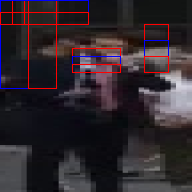

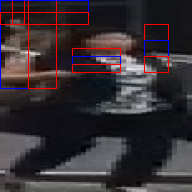

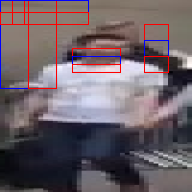

time: 104 ms (started: 2022-10-23 02:51:35 +00:00)


In [ ]:
iMasks = it[0:5] # guardamos los primeros 5 indices


# Se toman 3 imágenes
img1 = cv2.imread('pedestrian/1.png')
img2 = cv2.imread('pedestrian/10.png')
img3 = cv2.imread('pedestrian/12.png')

img1 = redimension2(img1)
img2 = redimension2(img2)
img3 = redimension2(img3)

for index in iMasks:
  DrawMask(img1, parameters[index])

for index in iMasks:
  DrawMask(img2, parameters[index])

for index in iMasks:
  DrawMask(img3, parameters[index])

cv2_imshow(img1)
cv2_imshow(img2)
cv2_imshow(img3)